## Train a rate network to generate sines at different frequencies in response to a static input.
    - Use FORCE to train a brian network to generate the latents, then use reward-based learning to change network behavior.

In [1]:
# import stuff
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.fft import fft,fftfreq
import datetime
import scipy
import pickle

In [2]:
# define a simple network composed of recurrent J weights and a single linear readout
class multiSpeedRNN(nn.Module):
    def __init__(self, nneurons: int = 200, save_path: str = None, lr: float =1e-3,
                 device: torch.device = None, dt: float=0.01, tau: float = 0.1):
        super().__init__()

        # will almost always want to use the CPU to train
        if device is None:
            self.device = torch.device('cpu')
            device = self.device
        else:
            self.device = device

        # initialize all of our weights and set a few parameters
        J_mat = (1.2 * np.random.randn(nneurons, nneurons)/np.sqrt(nneurons))
        self.J = nn.Parameter(torch.from_numpy(J_mat.astype(np.float32)).to(device))
        self.Wout = nn.Parameter(torch.from_numpy((np.random.randn(1, nneurons)/np.sqrt(nneurons)).astype(np.float32)).to(device))
        self.Win  = nn.Parameter(torch.from_numpy((np.random.randn(nneurons,1)/np.sqrt(nneurons)).astype(np.float32)).to(device))
        self.neural_nonlinearity = nn.Tanh()
        self.dt = dt
        self.tau = tau
        self.opt = torch.optim.Adam(self.parameters(), lr=lr)
        self.save_path = save_path
        self.movement_time_range = [0.1,6]
        self.input_on_time_range = [0,0]
        self.output_delay = 0
        self.Loss = []
        self.rates = None
        #self.create_targets_and_inputs()
        self.output = None
        self.inputs = None
        self.batch_size = 2
        self.initialState = torch.randn((self.J.shape[0], self.batch_size), device=device) / np.sqrt(self.J.shape[0])

    def create_targets_and_inputs(self, frequencies=None, amplitude: int = 1):

        if frequencies is None:
            frequencies = [1, 2]

        # choose a random time for the input to go high (start movement)
        #start_idx = np.random.randint(low=int(self.input_on_time_range[0]/self.dt),high=int(self.input_on_time_range[1]/self.dt))
        start_idx=0

        # index where the output starts
        #movement_start_idx = start_idx + int(self.output_delay / self.dt)
        movement_start_idx=0

        # choose a movement duration for this trial
        move_duration =  np.diff(self.movement_time_range)[0] * np.random.random() + self.movement_time_range[0]

        # calculate the total trial duration
        trial_time = move_duration + (movement_start_idx*self.dt)

        # duration of trial (in samples)
        trl_l = int(trial_time / self.dt) + 1

        # time vector (will be useful for creating targets)
        movement_times = np.arange(0,move_duration,self.dt)

        # define our input vectors
        inputs = np.zeros((trl_l,len(frequencies))) + (np.arange(len(frequencies))+1)

        # make the inputs turn on at startIdx
        inputs[:start_idx,:] = 0

        # define our outputs
        targets = np.zeros((trl_l,len(frequencies)))
        for ii in range(len(frequencies)):
            targets[movement_start_idx:,ii] = amplitude * np.sin(movement_times * (frequencies[ii] * 2 * np.pi))

        self.Targets = targets
        self.Inputs  = inputs

    def forward(self, targets: np.ndarray = None, inputs: np.ndarray = None, trial_length: int = None, noise_scale: float = 1e-5):
        device = self.device
        batch_size = 2
        Targets = torch.from_numpy(targets.astype(np.float32))
        Inputs = torch.from_numpy(inputs.astype(np.float32))
        position_store = torch.zeros(int(trial_length), batch_size)

        # cycle through trials
        for trl in range(batch_size):

            xm1 = self.initialState
            rm1 = self.neural_nonlinearity(xm1)

            for idx in np.arange(0,trial_length):
                xm1 = xm1 + self.dt/self.tau * (-xm1 + (self.J @ rm1 + (Inputs[idx,trl] * self.Win) +
                                            torch.randn(rm1.shape, device=device) * np.sqrt(noise_scale)))
                rm1 = self.neural_nonlinearity(xm1)
                position_store[idx,trl] = (self.Wout @ rm1)[0][0]

        # average loss over time and trials
        loss = ((Targets - position_store)**2).mean(axis=0).mean()

        self.output = position_store
        return loss


    def fit_initial_m1(self, trials: int = 1000):
        m1_params = [self.J, self.Wout, self.Win]
        optimizer = torch.optim.Adam(m1_params, lr=1e-3)
        for trial in range(trials):
            optimizer.zero_grad()
            self.create_targets_and_inputs()
            targets = self.Targets
            inputs  = self.Inputs
            loss = self.forward(targets = targets,inputs = inputs,trial_length = targets.shape[0])
            self.Loss.append(loss.item())
            loss.backward()
            optimizer.step()

    # return inputs, rates, targets, outputs, without any noise
    def returnRates(self, start_idx: int=0,move_duration: float=6.0):

        device = self.device

        # generate our inputs
        frequencies = [1,2]

        # number of conditions
        numConds = len(frequencies)

        # index where the output starts
        #movement_start_idx = start_idx + int(self.output_delay / self.dt)
        movement_start_idx = 0

        # calculate the total trial duration
        trial_time = move_duration + (movement_start_idx*self.dt)

        # duration of trial (in samples)
        trl_l = int(trial_time / self.dt)

        # time vector (will be useful for creating targets)
        movement_times = np.arange(0,move_duration,self.dt)

        # define our input vectors
        inputs = np.zeros((trl_l,len(frequencies))) + (np.arange(len(frequencies))+1)

        # make the inputs turn on at startIdx
        inputs[:start_idx,:] = 0

        # convert to tensor
        Inputs = torch.from_numpy(inputs.astype(np.float32))

        # define our outputs
        targets = np.zeros((trl_l,len(frequencies)))
        amplitude=1
        for ii in range(numConds):
            targets[movement_start_idx:,ii] = amplitude * np.sin(movement_times * (frequencies[ii] * 2 * np.pi))

        # run the model forward
        numNeurons = self.initialState.shape[0]

        # rates are T x N x C
        rates = np.zeros((trl_l,numNeurons,numConds))

        # output is T x C
        output = np.zeros((trl_l,numConds))

        # set the noise scale
        noise_scale = 1e-4

        # cycle through conditions
        for trl in range(numConds):

            xm1 = self.initialState
            rm1 = self.neural_nonlinearity(xm1)

            for idx in np.arange(0,trl_l):
                xm1 = xm1 + self.dt/self.tau * (-xm1 + (self.J @ rm1 + (Inputs[idx,trl] * self.Win) +
                                            torch.randn(rm1.shape, device=device) * np.sqrt(noise_scale)))
                rm1 = self.neural_nonlinearity(xm1)
                rates[idx,:,trl] = rm1.detach().numpy()[:,0]
                output[idx,trl]  = (self.Wout @ rm1).detach().numpy()[0][0]


        return inputs, targets, output, rates


### load the previously trained network

In [3]:
# path to saved weights
savePath = '/Users/andrew/Documents/GitHub/basal_ganglia/networks/trainedModels/multiSpeedCycling/'

# file name
fName = '2023-08-08 12_31_39.npy'

# load file
data = np.load(savePath + fName,allow_pickle=True)
data = data.ravel()[0]
model=data['full_model']

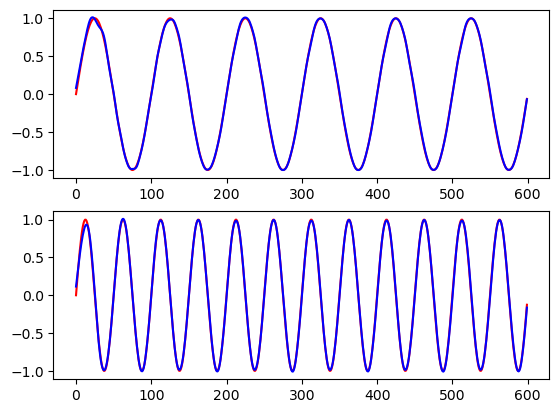

In [4]:
# return the rates (and inputs, targets, and outputs)
# rates are T x N x C
inputs, targets, output, rates = model.returnRates()

# pull out some useful numbers
trialDur, numN, numC = rates.shape

# plot target and output (just as a sanity check)
for ii in range(2):
    plt.subplot(2,1,ii+1)
    plt.plot(targets[:,ii],'r')
    plt.plot(output[:,ii],'b');


In [5]:
# run pca on the rates to get our targets for our FORCE networks

# turn rates into a CT x N matrix
rates_rs = rates.transpose(0,2,1).reshape(-1,numN,order='F')

pca = PCA(n_components=numN)
proj = pca.fit_transform(rates_rs)


In [46]:
print(np.sum(abs(Z[:,:,2]),axis=0))

[1597.70897911 1655.42668401]


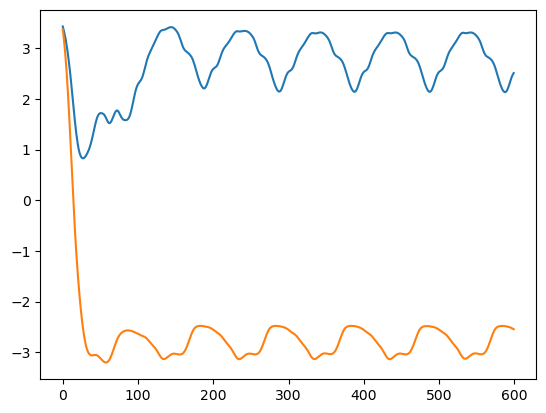

In [41]:
Z = proj.reshape(-1,2,200,order='F')
plt.plot(Z[:,:,2]);

### Sweep the amount of overlap between contexts and determine how much generalization occurs


#### bunch of functions that are necessary to run the experiment

In [6]:
# function for getting the rates from the trained network
def returnRates(u,ipt,w,j0,w_in,b=None,X0 = None,R0 = None,Z0 = None):

    ## initialize arrays to track rates and (if we are given a b) output of the network ##

    # useful numbers
    trlDuration, numConds = ipt.shape
    numLatents,numUnits = u.shape

    # initialize our matrices
    allRates   = np.zeros((trlDuration, numConds, numUnits))
    allLatents = np.zeros((trlDuration, numConds, numLatents))
    allOutputs = np.zeros((trlDuration,numConds))


    # cycle through conditions
    for cc in range(numConds):

        # set the inital states/rates/Z
        if X0 is None:
            x = np.copy(x0)
            r = np.copy(r0)
            z = np.copy(z0)
        else:
            x = np.copy(X0)
            r = np.copy(R0)
            z = np.copy(Z0)

        # cycle through time
        for ii in range(trlDuration):

            # update our state
            x += (1/tau) * (-x + (j0.T@r) + (u.T@z) + (ipt[ii,cc] * w_in))

            # calculate our current rate
            r = np.tanh(x)

            # calculate the current z
            z = w.T@r

            # save the rates
            allRates[ii,cc,:] = r[:,0]

            # save the latents
            allLatents[ii,cc,:] = z[:,0]

            # if we have an output vector, save network output
            if b is not None:
                allOutputs[ii,cc] = b.T@r

    # return output
    return allRates, allLatents, allOutputs

In [7]:
# returns latents scaled to preserve variance. Used in the overlap experiment
def returnScaledLatents(oLatents,sharedFraction):

    # oLatents are size T x K x 2. Generate 2 copies of each dimension, scale each copy.
    # If the shared fraction is 0, the second K dimensions during context 1 are just 0.
    # If the shared fraction is 1, both sets of K dimensions during context 1 are equally active.
    # Shared fraction of 0.5 -> second set of K dimensions is 0.5 as active during context 1

    # calculate the adjusted sizes of each sets of latents
    weightA = 1 / (1 + sharedFraction)
    weightB = sharedFraction * weightA

    # number of original latents
    numLats = oLatents.shape[1]

    # generate two copies of the latents
    latents_doubled = np.tile(oLatents,(1,2,1))

    # adjust the first set of latents for the first context
    latents_doubled[:,:numLats,0] = latents_doubled[:,:numLats,0] * np.sqrt(weightA)

    # adjust the second set of latents for the first context
    latents_doubled[:,numLats:,0] = latents_doubled[:,numLats:,0] * np.sqrt(weightB)

    # now do the same for context 2, switching weights A and B
    latents_doubled[:,:numLats,1] = latents_doubled[:,:numLats,1] * np.sqrt(weightB)
    latents_doubled[:,numLats:,1] = latents_doubled[:,numLats:,1] * np.sqrt(weightA)

    return latents_doubled

In [8]:
# function for returning initializing a FORCE network and training the weights
def trainFORCENetwork(z_target):

    ## draw our U and J0 weights ##

    # U first
    u = np.random.uniform(low=uMin,high=uMax, size=(numZ*2,numN)) * g_U

    # J0
    j0 = np.random.normal(loc=0, scale=(g_j0**2)/(numN * tau**2), size=(numN,numN))

    # W_in
    #W_in = model.Win.detach().numpy()
    w_in = np.random.uniform(low=uMin,high=uMax, size=(numN,1)) * g_W_in

    ## rename our inputs ##
    ipt = np.copy(inputs)

    # duration of our trials
    tDur = ipt.shape[0]

    ## initialize W ##
    w = np.random.normal(loc=0,scale=1/(numN * g_w),size=(numN,numZ*2))

    ## initial state, x0 ##
    x0 = np.random.normal(loc=0, scale=1,size=(numN,1)) / np.sqrt(numN)

    ## initial rate, r0 ##
    r0 = np.zeros((numN,1))

    ## initial latents, z0 ##
    z0 = np.zeros((numZ*2,1))

    ## initial value of P ##
    p = np.eye(numN) / alpha



    ## train the network ##
    # cycle through trials

    for trl in range(numTrials):

        # cycle through conditions
        for cc in range(2):

            # set the initial state, rate, and latent
            x = np.copy(x0)
            r = np.copy(r0)
            z = np.copy(z0)

            # cycle through the trial
            for ii in range(tDur):

                # update our state
                x += (1/tau) * (-x + (j0.T@r) + (u.T@z) + (ipt[ii,cc] * w_in)
                                + np.random.normal(loc = 0, scale = np.sqrt(noiseScale), size = x.shape))

                # calculate our current rate
                r = np.tanh(x)

                # calculate the current z
                z = w.T@r

                # calculate the error
                error = np.atleast_2d(z[:,0] - z_target[ii,:,cc])

                # update the weights
                w = w - ((p @ r)@error)

                # update P
                p = p - ((p @ r @ r.T @ p)/(1 + (r.T @ p @ r)))


    ## return trained weights ##
    return x0, r0, z0, j0, u, w_in, ipt, w, z_target

In [9]:
# function for learning a B for a trained network
def learnB(u,ipt,tgt,w,w_in,j0):

    ## use regression to define a B ##

    # get rates from the trained FORCE network
    rates,latents,_ = returnRates(u=u,ipt=ipt,w=w,j0=j0,w_in=w_in)

    # reshape to be CT x N
    rates_rs = rates.reshape(-1,numN,order='F');

    # reshape the targets from our rate network
    targets_rs = tgt.reshape(-1,1,order='F')

    # define a regularization term
    ridgeLambda = 1e-4

    # define the null space of W, project rates into this space
    w_null = scipy.linalg.null_space(w.T)
    rates_null = rates_rs@w_null

    # regress
    b_null = np.linalg.inv(rates_null.T @ rates_null + np.eye(rates_null.shape[1]) * ridgeLambda) @ rates_null.T @ targets_rs
    b = w_null@b_null

    return b

In [10]:
# calculate the alignment between conditions
def calculateAI(X1,X2,numDims):

    # calculate the covariance matrix of X2
    X2_center = X2 - np.mean(X2, axis=0)
    C2 = (X2_center.T @ X2_center) / (X2_center.shape[0]-1)

    # run pca on X1 and X2
    pca1 = PCA(n_components=numDims)
    pca1.fit(X1)

    pca2 = PCA(n_components=numDims)
    pca2.fit(X2)

    # grab the pcs from X1 (spits out a k x N matrix by default)
    W = pca1.components_.T

    # calculate the variance explained by the top 'nDims' PCs of X2
    totVar = sum(pca2.explained_variance_)

    # calculate alignment index
    AI = np.trace((W.T @ C2 @ W)) / totVar

    return AI

In [82]:
# function that learns a dU to change the cycling frequency in one context

def runSingleDirectionLearning(IN,w,u,j0,w_in,b,numTrials=10,alpha=1,pertMag=1e-3,ampChangeThreshold = 0.05,targetFreq = 1.8, zRateScale = 5):


    # initialize the U (keep it separate from our original U
    U_learn = np.copy(u)

    # grab the norm of the original U weights
    U_norm = np.linalg.norm(U_learn,axis=1)

    # generate the output for the current U
    _,_,originalOutput = returnRates(u = U_learn,ipt = IN,b=b,w=w,j0=j0,w_in=w_in)

    # current speed
    currentFreq = returnPeakFreq(originalOutput[:,0],minFreq = 1.9, maxFreq = 2.1, numFreqs=100)

    # calculate error between target frequency and current frequency
    error = (targetFreq - currentFreq)**2

    # keep track of our speed in each context
    allError = np.zeros(numTrials)

    # keep track of the amplitude
    allAmp = np.zeros(numTrials)

    # get the amplitude of the current output
    oAmp = np.max(originalOutput[-200:,0])

    # allowed amplitude range (after perturbation)
    maxAmp = oAmp + (oAmp * ampChangeThreshold)
    minAmp = oAmp - (oAmp * ampChangeThreshold)

    # amplitude of current best output
    cAmp = oAmp



    # cycle through trials
    for ii in range(numTrials):

        # generate a perturbation matrix for U.
        dU = 2 * np.random.random_sample(size=u.shape) -1

        # scale each row of U to have a magnitude of 'pertMag'
        dU = (dU.T/ np.linalg.norm(dU,axis=1)).T
        dU = dU * pertMag

        # generate our perturbed U
        U_pert = U_learn + dU

        # re-normalize
        U_pert = (U_pert.T / np.linalg.norm(U_pert,axis=1)).T
        U_pert = U_pert * U_norm[:,np.newaxis]

        # generate a perturbed output
        _,pertZ,newOutput = returnRates(u = U_pert,ipt = IN,b=b,w=w,j0=j0,w_in=w_in)

        # calculate the mean absolute rate of each factor during this trial
        meanZ = np.mean(abs(pertZ),axis=0).squeeze()

        # scale this mean such that the max value is approximately 1
        meanZ_scaled = meanZ / zRateScale

        # calculate the new frequency
        nFreq = returnPeakFreq(newOutput[:,0],minFreq = currentFreq-0.1, maxFreq = currentFreq+0.1)

        # calculate new error
        nError = (nFreq - targetFreq)**2

        # check that our amplitude hasn't changed too much
        pertAmp = np.max(abs(newOutput[-200:,0]))

        # incorporate the change if things got better
        if (nError < error) & (minAmp <= pertAmp <= maxAmp):
            U_learn = np.copy(U_learn + (dU * meanZ_scaled[:,np.newaxis]))
            error = nError
            currentFreq = np.copy(nFreq)
            cAmp = pertAmp

        # save our error
        allError[ii] = error
        allAmp[ii] = cAmp

    # return error and our learned U
    return U_learn,allError,allAmp

In [12]:
# function for returning peak frequency of a 1d Trace
# FFT doesn't give me the resolution I want, so just make a bunch of waves at different frequencies and ask which one matches our signal best

def returnPeakFreq(signal, minFreq = 0.8, maxFreq = 1.2, numFreqs = 100):

    # length of our signal
    L = signal.shape[0]

    # time vector
    t = np.arange(L)

    # vector of frequencies to test
    freqs = np.linspace(minFreq,maxFreq,numFreqs)

    # vector to hold the dot product of our signal and the waves we make
    mags = np.zeros(numFreqs) + np.nan

    # cycle through all of our frequencies
    for idx,f in enumerate(freqs):

        # make our templates
        testSin = np.sin(f*0.01 * 2 * np.pi * t)
        testCos = np.cos(f*0.01 * 2 * np.pi * t)

        mags[idx] = np.dot(signal,testSin) + np.dot(signal,testCos)

    # return the frequency that matches best
    return freqs[np.argmax(mags)]

# function for returning the MSE between two traces, after one has been stretched to match the other.
def calculateAdjustedMSE(signal1, signal2, freq1, freq2):

    # duration of original signal
    oSignalDur = signal1.size

    # figure out which signal needs to be stretched
    if freq1 < freq2:
        slowSignal = signal1
        fastSignal = signal2
        slowFreq = freq1
        fastFreq = freq2
        stretchFlag = True
    elif freq2 < freq1:
        slowSignal = signal2
        fastSignal = signal1
        slowFreq = freq2
        fastFreq = freq1
        stretchFlag = True
    else:
        # if both signals have the same dominant frequency, no need to do any stretching
        slowSignal = signal1
        fastSignal = signal2
        stretchFlag = False

    if stretchFlag:

        # calculate the ratio of the fast signal to the slow signal
        freqRatio = fastFreq/slowFreq

        # generate a stretched time base for the faster signal
        fastTimes_stretched = np.arange(0,oSignalDur) * freqRatio

        # interpolate the faster signal to get a signal the same length as the slow signal
        fastSignal = np.interp(np.arange(0,oSignalDur),fastTimes_stretched,fastSignal)

    # now calculate the MSE
    return ((slowSignal - fastSignal)**2).mean()

In [13]:
## set some parameters for this experiment ##

# overlaps to test
OVERLAPS = [0,0.001,0.01,0.1,0.2,0.4]

# original network will be trained to cycle at 2 Hz in context 1
# how fast should the network cycle after learning?
postLearningTargetFreq = 1.8

# number of networks to train per overlap
numNetworks = 1

# number of times to repeat learning experiment
numLearningExperiments = 2

# magnitude of the U perturbation
uPertMag = 1e-3

## parameters related to the FORCE network ##

# network time constant (in msec)
tau = 10

# gain for U weights
g_U = 0.1

# U weights are drawn from a uniform distribution. Set range of this distribution
uMin = -1
uMax = 1

# gain for the input weights
g_W_in = 0.1

# gain for J0 weights. We want these to be fairly small.
g_j0 = 0.5

# gain for initial W weights
g_w  = 0.025

# initial learning rate
alpha = 1

# number of latents
numZ = 10

# number of training trials
numTrials = 30

## scale of the training noise ##
noiseScale = 1e-6

## original K projections from the rate network ##
Z_target_original = proj.reshape(-1,2,numN,order='F').transpose(0,2,1)[:,:numZ,:]

In [14]:
## run the experiment ##

# initialize lists to hold trained weights, initial values, learned U's
allW    = []
allW_in = []
allJ0   = []
allB    = []
allU    = []

allx0   = []
allr0   = []
allz0   = []

allZ_target = []
allInput    = []

allU_learned = []

allAI = []

# list to hold pre and post-training learned frequencies for both contexts
preLearningTrainingContextFreq = []
postLearningTrainingContextFreq = []

preLearningTestingContextFreq = []
postLearningTestingContextFreq = []

# cycle through networks
for nn in range(len(OVERLAPS)):

    # where are we in the training?
    print('training network ' + str(nn) + ' of ' + str(len(OVERLAPS)))

    # generate our scaled Z_targets
    scaledZ = returnScaledLatents(Z_target_original,OVERLAPS[nn])

    # generate our FORCE network
    x0, r0, z0, j0, u, w_in, ipt, w, z_target = trainFORCENetwork(scaledZ)

    # learn a B
    b = learnB(u,ipt,targets,w,w_in,j0)

    # calculate alignment index
    rates,_,_ = returnRates(u=u,ipt=ipt,b=b,w=w,j0=j0,w_in=w_in)

    allAI.append(calculateAI(rates[:,0,:].squeeze(),rates[:,1,:].squeeze(),10))

    # save everything from this network
    allW.append(w)
    allU.append(u)
    allW_in.append(w_in)
    allJ0.append(j0)
    allB.append(b)

    allx0.append(x0)
    allr0.append(r0)
    allz0.append(z0)

    allZ_target.append(z_target)
    allInput.append(ipt)


    # generate a longer input for our learning experiment
    trainingInput = np.zeros((1000,1)) + 2
    testingInput  = np.zeros((1000,1)) + 1

    # cycle through repetitions of the training experiment
    temp_preLearningFreq_ctx0 = []
    temp_preLearningFreq_ctx1 = []

    temp_postLearningFreq_ctx0 = []
    temp_postLearningFreq_ctx1 = []

    temp_uLearned = []

    # calculate pre-training frequency
    _,_,out0_training = returnRates(u=u,ipt=trainingInput,b=b,w=w,j0=j0,w_in=w_in)
    _,_,out0_testing = returnRates(u=u,ipt=testingInput,b=b,w=w,j0=j0,w_in=w_in)
    freq0_training = returnPeakFreq(out0_training[:,0],minFreq = 1.9, maxFreq = 2.1)
    freq0_testing = returnPeakFreq(out0_testing[:,0],minFreq = 0.9, maxFreq = 1.1)


    for rr in range(numLearningExperiments):

        # run experiment
        u_l,_,_ = runSingleDirectionLearning(IN=trainingInput,numTrials=800,alpha=1,pertMag=uPertMag,ampChangeThreshold = 0.02,targetFreq = postLearningTargetFreq,w=w,u=u,j0=j0,w_in=w_in,b=b)

        # plot results
        _,_,outTraining = returnRates(u=u_l,ipt=trainingInput,b=b,w=w,j0=j0,w_in=w_in)
        _,_,outTesting = returnRates(u=u_l,ipt=testingInput,b=b,w=w,j0=j0,w_in=w_in)

        # calculate final speeds
        freqTraining = returnPeakFreq(outTraining[:,0],minFreq = 1.7, maxFreq = 2.0, numFreqs = 500)
        freqTesting = returnPeakFreq(outTesting[:,0],minFreq = 0.7, maxFreq = 1.0, numFreqs = 500)

        # save everything
        temp_preLearningFreq_ctx1.append(freq0_training)
        temp_preLearningFreq_ctx0.append(freq0_testing)

        temp_postLearningFreq_ctx1.append(freqTraining)
        temp_postLearningFreq_ctx0.append(freqTesting)

        temp_uLearned.append(u_l)

    # add everything to the larger list
    allU_learned.append(temp_uLearned)

    preLearningTrainingContextFreq.append(temp_preLearningFreq_ctx1)
    postLearningTrainingContextFreq.append(temp_postLearningFreq_ctx1)

    preLearningTestingContextFreq.append(temp_preLearningFreq_ctx0)
    postLearningTestingContextFreq.append(temp_postLearningFreq_ctx0)


training network 0 of 6
training network 1 of 6
training network 2 of 6
training network 3 of 6
training network 4 of 6
training network 5 of 6


In [15]:
# save everything
savePath = '/Users/andrew/Documents/GitHub/basal_ganglia/networks/trainedModels/overlapExperiment/'

# get current time
ct = str(datetime.datetime.now())[:19]

# replace colons with an underscore
ct = ct.replace(':','_')

# set up the path and dictionary
savePath = savePath
data_dict = {'allJ0': allJ0, 'allU': allU,'allW': allW, 'allW_in': allW_in,
             'allx0': allx0, 'allr0': allr0, 'allz0': allz0,
             'allZ_target': allZ_target, 'allInput': allInput,
             'allU_learned': allU_learned,'OVERLAPS': OVERLAPS,'allAI': allAI}
np.save(savePath + ct + '.npy',data_dict)

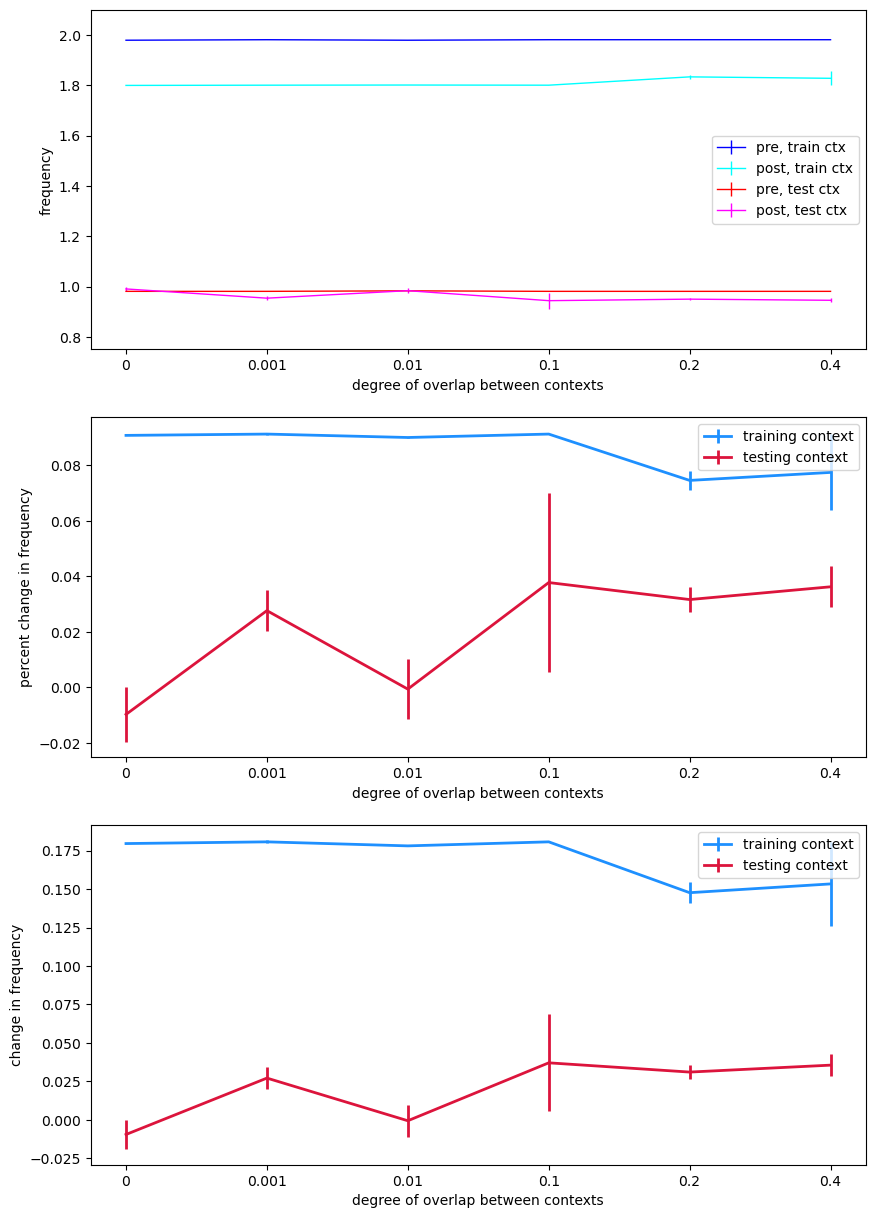

In [16]:
# plot results
# plotting parameters
lineWidth = 1

# number of networks
numNets = len(OVERLAPS)

# import function for unpacking nested lists
from itertools import chain

# unpack all of our frequencies (pre and post training, context0 and context1)
# reshape to be size numReps x numNetworks
preTrain  = np.array(list(chain.from_iterable(preLearningTrainingContextFreq))).reshape(numLearningExperiments,-1,order='F')
postTrain = np.array(list(chain.from_iterable(postLearningTrainingContextFreq))).reshape(numLearningExperiments,-1,order='F')

preTest  = np.array(list(chain.from_iterable(preLearningTestingContextFreq))).reshape(numLearningExperiments,-1,order='F')
postTest = np.array(list(chain.from_iterable(postLearningTestingContextFreq))).reshape(numLearningExperiments,-1,order='F')

# calculate mean and std of each network
preTrain_mean = np.mean(preTrain,axis=0)
postTrain_mean = np.mean(postTrain,axis=0)
preTest_mean = np.mean(preTest,axis=0)
postTest_mean = np.mean(postTest,axis=0)

preTrain_std = np.std(preTrain,axis=0)
postTrain_std = np.std(postTrain,axis=0)
preTest_std = np.std(preTest,axis=0)
postTest_std = np.std(postTest,axis=0)

# calculate percent change in frequency
pctChange_train = (preTrain - postTrain) / preTrain
pctChange_test = (preTest - postTest) / preTest

# calculate mean and std
pctChange_train_mean = np.mean(pctChange_train,axis=0)
pctChange_test_mean = np.mean(pctChange_test,axis=0)

pctChange_train_std = np.std(pctChange_train,axis=0)
pctChange_test_std = np.std(pctChange_test,axis=0)

# calculate change in frequency
dTrain = preTrain - postTrain
dTest  = preTest  - postTest

dTrain_mean = np.mean(dTrain,axis=0)
dTest_mean = np.mean(dTest,axis=0)
dTrain_std = np.std(dTrain,axis=0)
dTest_std = np.std(dTest,axis=0)


# plot

# plot frequency of each output
plt.figure(figsize = (10,15));
plt.subplot(3,1,1);
plt.errorbar(x=np.arange(numNets),y=preTrain_mean,yerr=preTrain_std,color='blue',linewidth=lineWidth,label='pre, train ctx')
plt.errorbar(x=np.arange(numNets),y=postTrain_mean,yerr=postTrain_std,color='cyan',linewidth=lineWidth,label='post, train ctx')

plt.errorbar(x=np.arange(numNets),y=preTest_mean,yerr=preTest_std,color='red',linewidth=lineWidth,label='pre, test ctx')
plt.errorbar(x=np.arange(numNets),y=postTest_mean,yerr=postTest_std,color='magenta',linewidth=lineWidth,label='post, test ctx')
plt.legend()
plt.xticks(ticks=np.arange(numNets),labels = OVERLAPS)
plt.ylim([0.75,2.1])

plt.xlabel('degree of overlap between contexts');
plt.ylabel('frequency');


# plot percent change in frequency for each context
plt.subplot(3,1,2);

plt.errorbar(x=np.arange(numNets),y=pctChange_train_mean,yerr=pctChange_train_std,color='dodgerblue',linewidth=lineWidth+1,label='training context')
plt.errorbar(x=np.arange(numNets),y=pctChange_test_mean,yerr=pctChange_test_std,color='crimson',linewidth=lineWidth+1,label='testing context')
plt.legend()

plt.xticks(ticks=np.arange(numNets),labels = OVERLAPS)

plt.xlabel('degree of overlap between contexts');
plt.ylabel('percent change in frequency');

# plot change in frequency
plt.subplot(3,1,3);

plt.errorbar(x=np.arange(numNets),y=dTrain_mean,yerr=dTrain_std,color='dodgerblue',linewidth=lineWidth+1,label='training context')
plt.errorbar(x=np.arange(numNets),y=dTest_mean,yerr=dTest_std,color='crimson',linewidth=lineWidth+1,label='testing context')
plt.legend()

plt.xticks(ticks=np.arange(numNets),labels = OVERLAPS)

plt.xlabel('degree of overlap between contexts');
plt.ylabel('change in frequency');



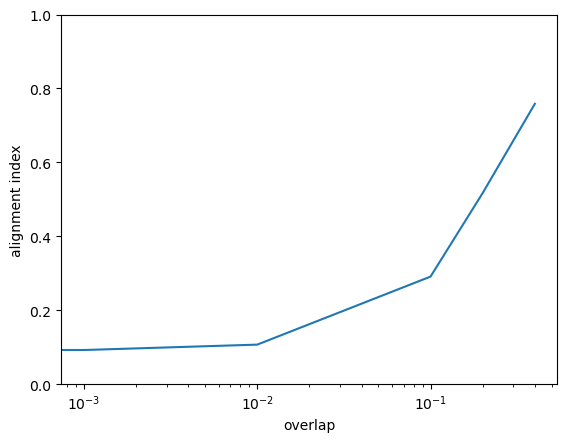

In [20]:
# plot alignment index as a function of degree of overlap in the latents

# plot
fig,ax = plt.subplots()
ax.semilogx(OVERLAPS,allAI)
plt.xlabel('overlap');
plt.ylabel('alignment index');
plt.ylim([0,1]);

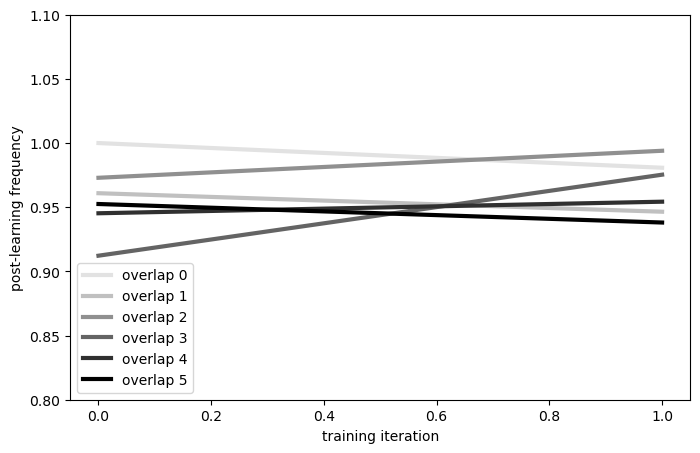

In [18]:
# plot post-training generalization performance for each network
import matplotlib
plt.figure(figsize=(8,5))
cmap = matplotlib.colormaps['Greys']
colors = cmap(np.linspace(0.2,1,6))
for ii in range(6):
    plt.plot(postTest[:,ii],color=colors[ii,:],linewidth=3,label = 'overlap ' + str(ii))

plt.ylim([0.8, 1.1])
plt.legend()
plt.xlabel('training iteration');
plt.ylabel('post-learning frequency');



original output (training): 1.9808080808080808
post-learning output (training): 1.9074148296593187
original output (testing): 0.9808080808080809
post-learning output (testing): 0.9591182364729458


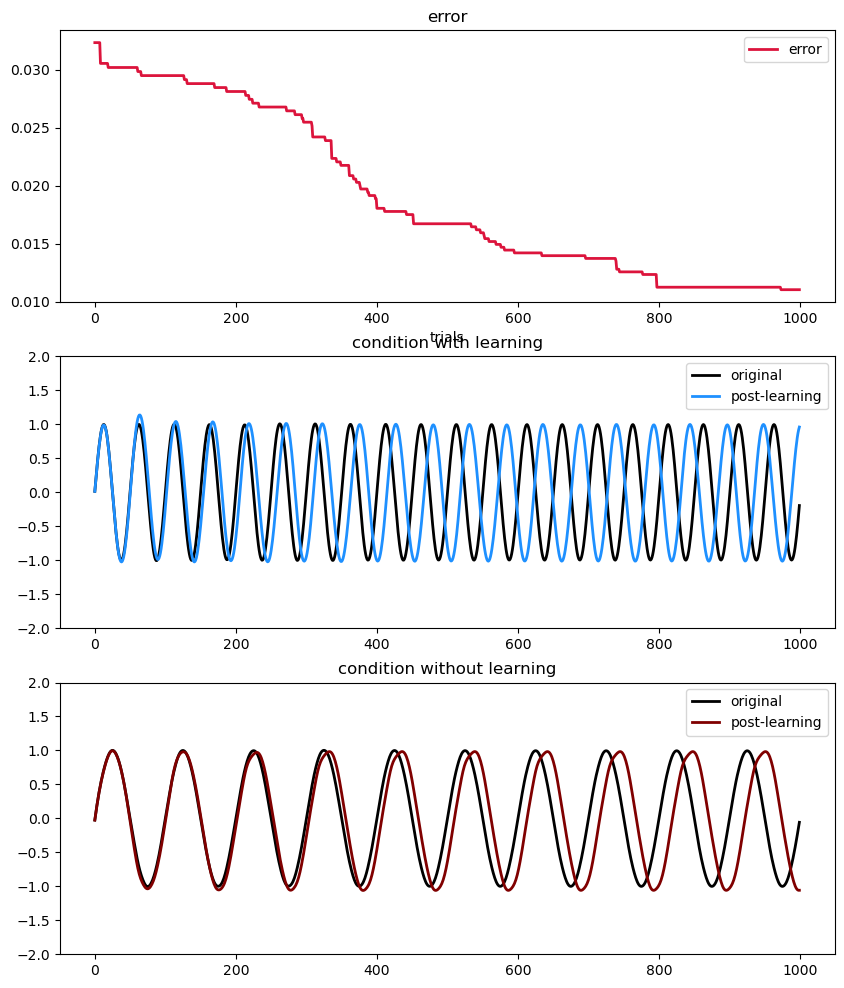

In [83]:
# quick code for running the learning experiment with a trained network

# index of the network we want to look at
idx = 4

# grab all of our trained weights
u    = allU[idx]
w    = allW[idx]
w_in = allW_in[idx]
j0   = allJ0[idx]
b    = allB[idx]

x0 = allx0[idx]
r0 = allr0[idx]
z0 = allz0[idx]

ipt = allInput[idx]
z_target = allZ_target[idx]

# run the learning experiment
trainingInput = np.zeros((1000,1)) + 2
testingInput  = np.zeros((1000,1)) + 1

_,_,out0_training = returnRates(u=u,ipt=trainingInput,b=b,w=w,j0=j0,w_in=w_in)
_,_,out0_testing = returnRates(u=u,ipt=testingInput,b=b,w=w,j0=j0,w_in=w_in)
freq0_training = returnPeakFreq(out0_training[:,0],minFreq = 1.9, maxFreq = 2.1)
freq0_testing = returnPeakFreq(out0_testing[:,0],minFreq = 0.9, maxFreq = 1.1)

u_l,allError,_ = runSingleDirectionLearning(IN=trainingInput,numTrials=1000,alpha=1,pertMag=uPertMag,ampChangeThreshold = 0.02,targetFreq = postLearningTargetFreq,w=w,u=u,j0=j0,w_in=w_in,b=b)

# plot results
_,_,outTraining = returnRates(u=u_l,ipt=trainingInput,b=b,w=w,j0=j0,w_in=w_in)
_,_,outTesting = returnRates(u=u_l,ipt=testingInput,b=b,w=w,j0=j0,w_in=w_in)

# calculate final speeds
freqTraining = returnPeakFreq(outTraining[:,0],minFreq = 1.7, maxFreq = 2.0, numFreqs = 500)
freqTesting = returnPeakFreq(outTesting[:,0],minFreq = 0.7, maxFreq = 1.0, numFreqs = 500)

print('original output (training): ' + str(freq0_training))
print('post-learning output (training): ' + str(freqTraining))

print('original output (testing): ' + str(freq0_testing))
print('post-learning output (testing): ' + str(freqTesting))

# plot error
plt.figure(figsize=(10,12))
plt.subplot(3,1,1);
plt.plot(allError,'crimson',linewidth=2,label='error')
plt.title('error')
plt.xlabel('trials')
plt.legend()

# plot output in the training condition
plt.subplot(3,1,2)

plt.plot(out0_training[:,0],'k',linewidth=2,label='original')
plt.plot(outTraining[:,0],'dodgerblue',linewidth=2,label='post-learning')
plt.ylim([-2,2])
plt.legend()
plt.title('condition with learning');

# plot output in the testing condition
plt.subplot(3,1,3)

plt.plot(out0_testing[:,0],'k',linewidth=2,label='original')
plt.plot(outTesting[:,0],'maroon',linewidth=2,label='post-learning')
plt.ylim([-2,2]);
plt.legend()
plt.title('condition without learning');